In [ ]:
# This notebook performs a statistical analysis of mice doing the cloud of tones task
# stimulating the dopamine release in the tail of the striatum

In [1]:
# run this on Colab
!rm -rf APE_paper/
!git clone https://github.com/HernandoMV/APE_paper.git
%pip install mouse-behavior-analysis-tools
%cd APE_paper/docs/figures_notebooks

Cloning into 'APE_paper'...
remote: Enumerating objects: 1094, done.
remote: Counting objects: 100% (194/194), done.
remote: Compressing objects: 100% (121/121), done.
remote: Total 1094 (delta 102), reused 156 (delta 73), pack-reused 900 (from 1)
Receiving objects: 100% (1094/1094), 70.94 MiB | 13.17 MiB/s, done.
Resolving deltas: 100% (499/499), done.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 11.6 MB/s eta 0:00:00
/content/APE_paper/docs/figures_notebooks


In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
from os.path import exists
import urllib.request
import matplotlib.pylab as plt
import warnings
from ast import literal_eval

from mouse_behavior_analysis_tools.utils import custom_functions as cuf
from mouse_behavior_analysis_tools.utils.misc_utils import update_progress
from mouse_behavior_analysis_tools.plot import make_figures
warnings.filterwarnings('ignore')

In [2]:
# download data from server
dataset_name = 'DA-optostimulation_dataframe.csv'
url = "https://zenodo.org/record/7261639/files/" + dataset_name
dataset_path = '../../data/' + dataset_name
# download if data is not there
if not exists(dataset_path):
    print('Downloading data...')
    urllib.request.urlretrieve(url, dataset_path)
else:
    print('Data already in directory')
# load
dao_df = pd.read_csv(dataset_path, index_col=0)

Data already in directory


In [3]:
# reconvert column to a diccionary
dao_df['FullGUI'] = [literal_eval(x) for x in dao_df.FullGUI]

In [4]:
# Select how to group trial numbers to compare
ini_trials = 150 # initial trials without stimulation
ao_trials = 151 # trials without stimulation, after some sampling

#### Generate **Figure 6C**

 - Progress: [####################] 100.0%


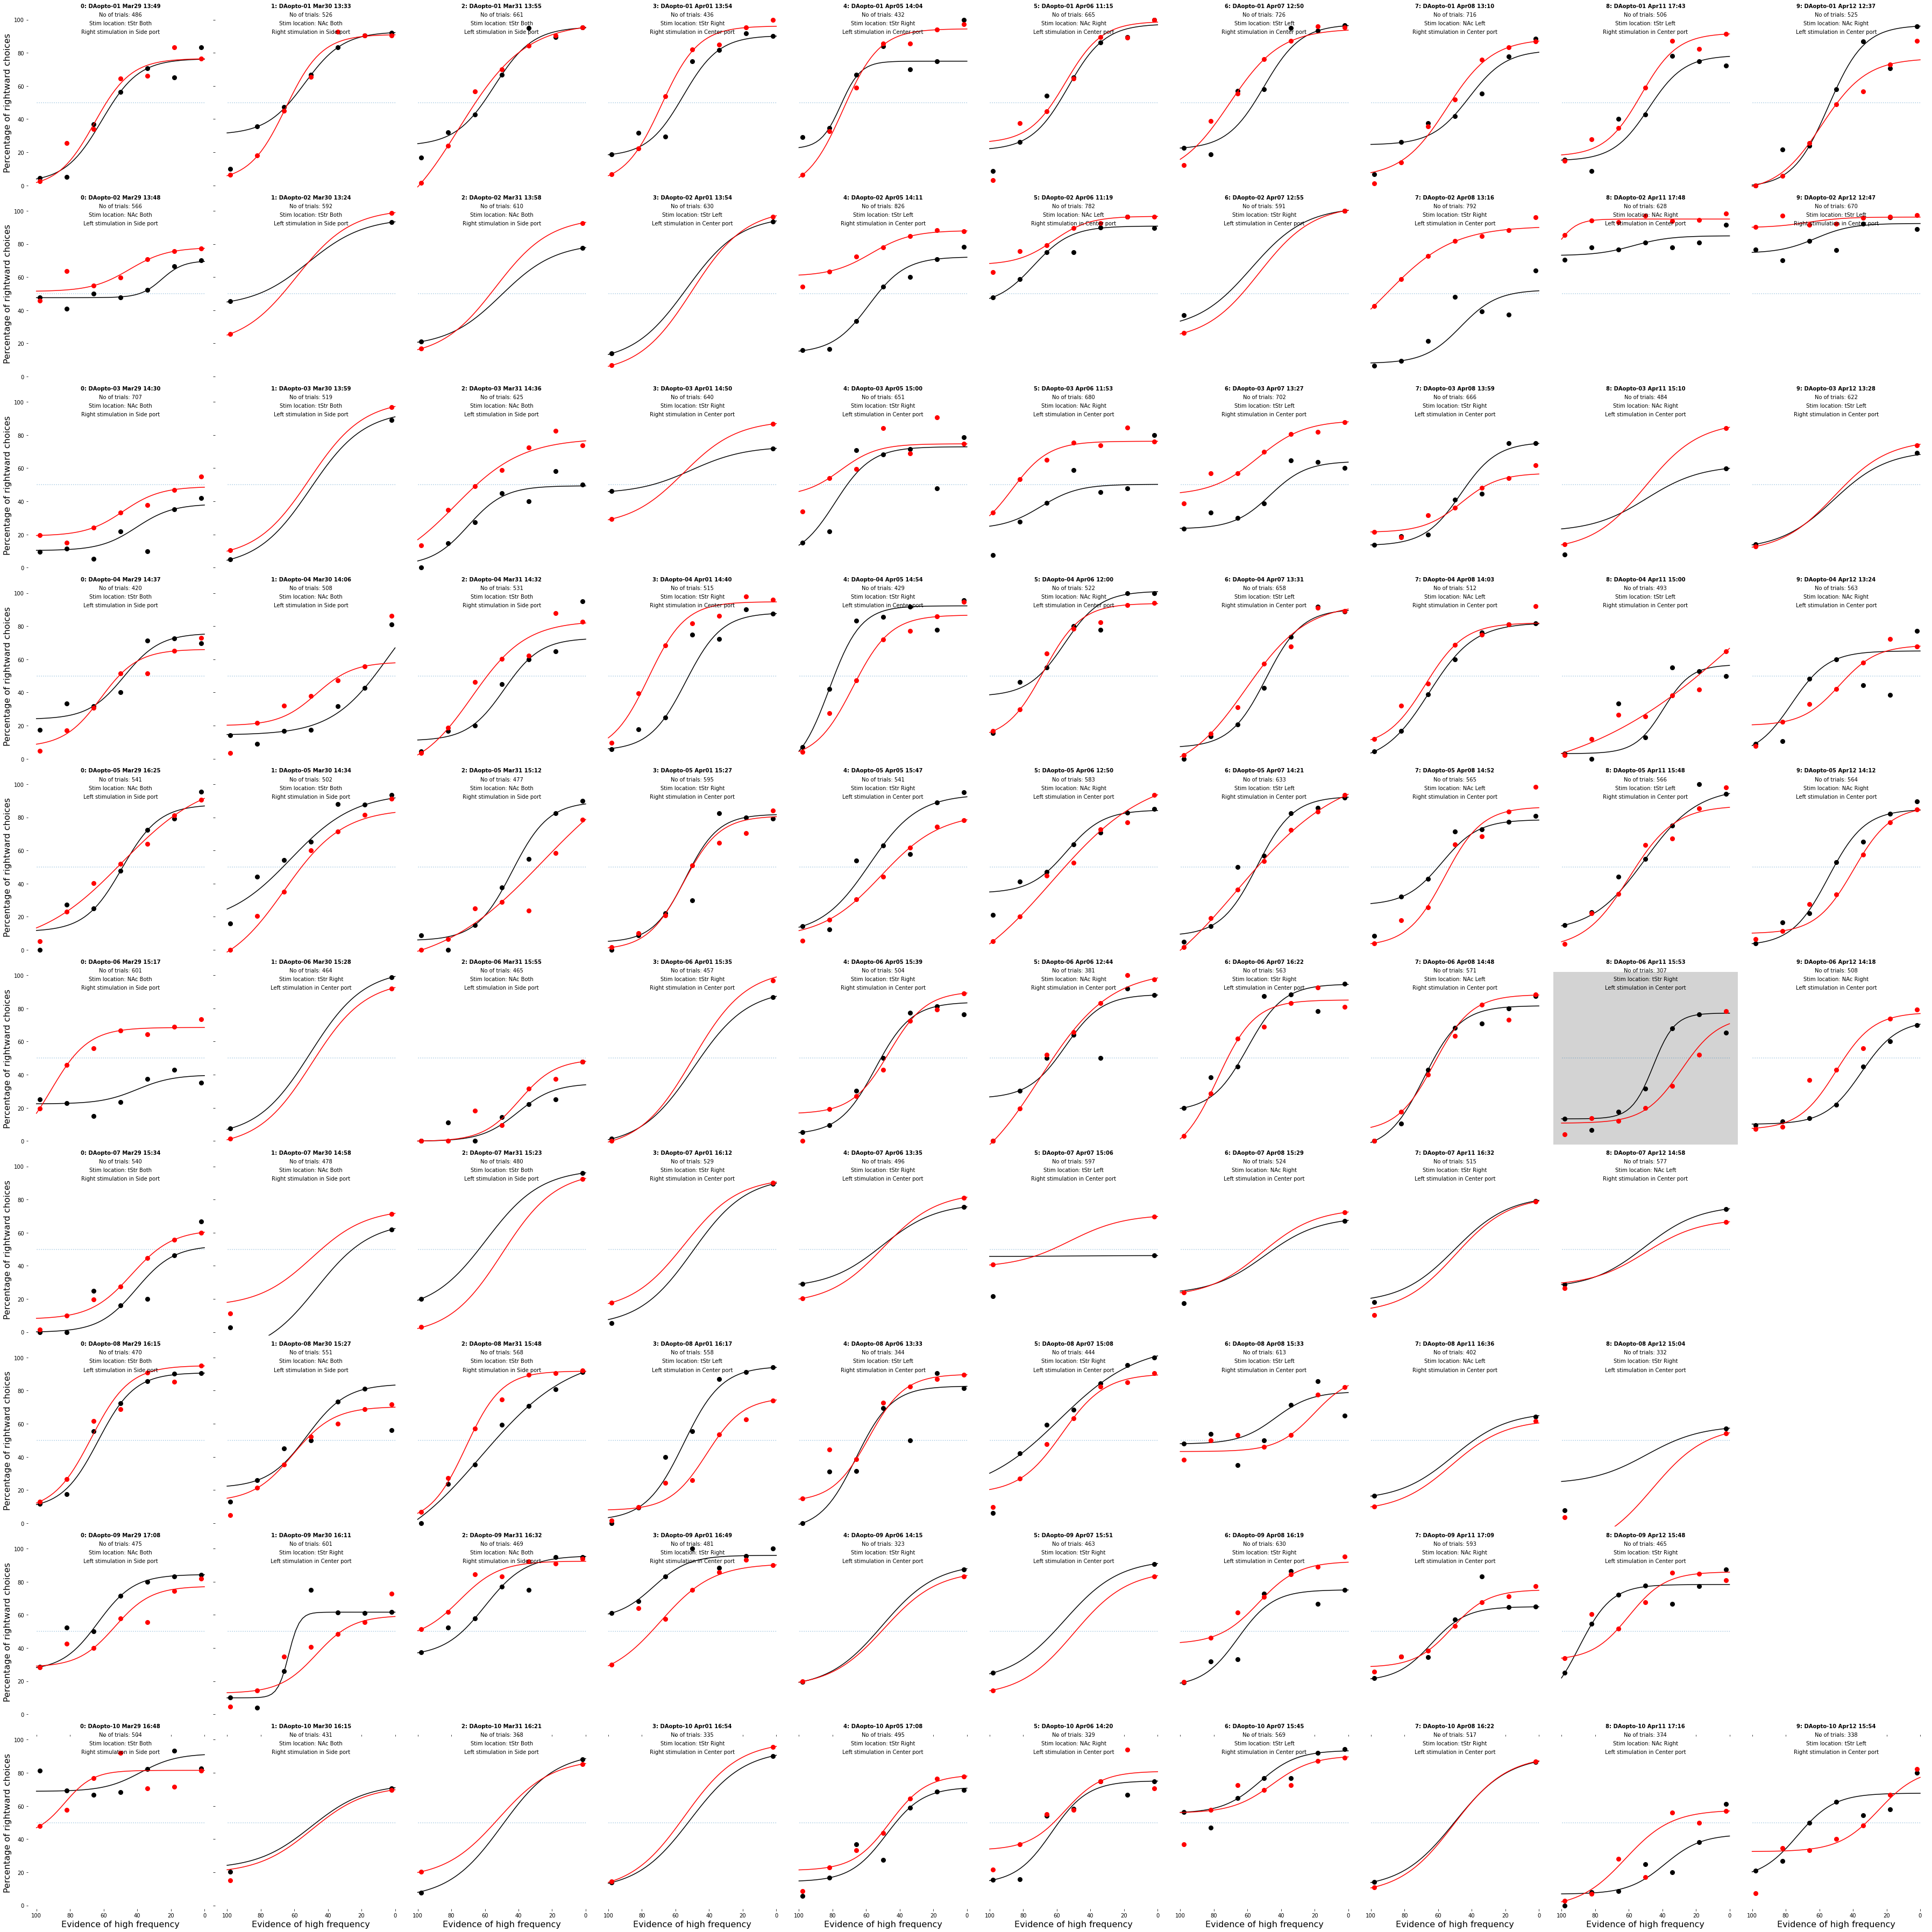

In [5]:
# see all the sessions done per animal
# highlight the session used as an example in the paper:
example_session = 'DAopto-06 Apr11 15:53'
fig = make_figures.make_figure_opto_da_all_mice(dao_df, ini_trials, ao_trials, example_session)
plt.show(fig)
# uncomment here to save the plot
# data_directory = ''
# plt.savefig(data_directory + 'optoinhibition_through_learning_per-mouse.pdf',
#             transparent=True, bbox_inches='tight')


In [6]:
# Generate a polished dataset for sharing.
dao_df.columns

Index(['AnimalID', 'ExperimentalGroup', 'SessionTime', 'FullSessionTime',
       'Protocol', 'Stimulation', 'Muscimol', 'RewardChange',
       'RewardChangeBlock', 'CenterPortDuration', 'Contingency',
       'RewardAmount', 'PunishDelay', 'Punish', 'BiasCorrection', 'TrialIndex',
       'TrialHighPerc', 'Outcomes', 'OptoStim', 'FirstPokeCorrect',
       'FirstPoke', 'TrialSide', 'TrialSequence', 'ResponseTime',
       'TrialStartTimestamp', 'CumulativePerformance', 'SwitchSide',
       'PreviousChoice', 'TrialEvents', 'TrialStates', 'FullGUI', 'SessionID',
       'ITIs', 'CumulativeTrialNumber', 'CumulativeTrialNumberByProtocol',
       'CurrentPastPerformance20', 'CurrentPastPerformance100',
       'NoOfCenterPokes', 'MiddleWaitTime', 'TrialInitiationTime', 'RightBias',
       'TrialsSpeed', 'PrevTrialSuccess'],
      dtype='object')

In [7]:
clean_df = dao_df.copy()
BRS = ["tStr", "NAc"]
PS = ["Left", "Right"]
PI = ["Center", "Side"]
# rename a column
clean_df.rename(columns={'Stimulation': 'SideOfFiber'}, inplace=True)
# find relevant info
clean_df["FiberLocation"] = [BRS[y] for y in [int(dao_df.iloc[x].FullGUI["FiberLocation"]) -1 for x in range(len(dao_df))]]
clean_df["PortWhereStimulationOccurred"] = [PI[y] for y in [int(dao_df.iloc[x].FullGUI["OptoState"]) -1 for x in range(len(dao_df))]]
clean_df["TrialOrMovementTrigerringStimulation"] = [PS[y] for y in [int(dao_df.iloc[x].FullGUI["JOPSide"]) -1 for x in range(len(dao_df))]]

In [9]:
# Find the bug
problem_df = clean_df[clean_df.PortWhereStimulationOccurred=='Center']
# trials after stimulation
problem_df = problem_df[problem_df.TrialIndex > ao_trials]

simple_df = problem_df[["SideOfFiber", "TrialOrMovementTrigerringStimulation", "TrialSide", "FirstPoke", "OptoStim", "FirstPokeCorrect"]]
simple_df

,SideOfFiber,TrialOrMovementTrigerringStimulation,TrialSide,FirstPoke,OptoStim,FirstPokeCorrect
11530,Right,Right,1.0,1.0,0.0,1.0
11531,Right,Right,1.0,1.0,0.0,1.0
11532,Right,Right,1.0,1.0,0.0,1.0
11533,Right,Right,1.0,1.0,0.0,1.0
11534,Right,Right,1.0,2.0,1.0,0.0
...,...,...,...,...,...,...
164397,Left,Right,1.0,1.0,0.0,1.0
164402,Left,Right,2.0,1.0,0.0,0.0
164406,Left,Right,1.0,1.0,0.0,1.0
164408,Left,Right,1.0,2.0,1.0,0.0


In [10]:
"""
Case 1: Trial types to the right should trigger stimulation: TrialSide - OptoStim = 1 in all cases
"""
caseonedf = simple_df[simple_df.TrialOrMovementTrigerringStimulation=='Right']
rightidx = caseonedf.index[caseonedf.TrialSide - caseonedf.OptoStim != 1]
simple_df.loc[rightidx]
# They are all incorrect trials.

,SideOfFiber,TrialOrMovementTrigerringStimulation,TrialSide,FirstPoke,OptoStim,FirstPokeCorrect
11534,Right,Right,1.0,2.0,1.0,0.0
11538,Right,Right,1.0,2.0,1.0,0.0
11541,Right,Right,1.0,2.0,1.0,0.0
11543,Right,Right,1.0,2.0,1.0,0.0
11553,Right,Right,2.0,1.0,0.0,0.0
...,...,...,...,...,...,...
164389,Left,Right,2.0,1.0,0.0,0.0
164390,Left,Right,2.0,1.0,0.0,0.0
164396,Left,Right,1.0,2.0,1.0,0.0
164402,Left,Right,2.0,1.0,0.0,0.0


In [11]:
# Same should happen for the left:
"""
Case 2: Trial types to the left should trigger stimulation: TrialSide + OptoStim = 2 in all cases
"""
casetwodf = simple_df[simple_df.TrialOrMovementTrigerringStimulation=='Left']
# find the indeces of the above
leftidx = casetwodf.index[casetwodf.TrialSide + casetwodf.OptoStim != 2]
simple_df.loc[leftidx]
# They are all incorrect trials as well.

,SideOfFiber,TrialOrMovementTrigerringStimulation,TrialSide,FirstPoke,OptoStim,FirstPokeCorrect
12406,Right,Left,1.0,2.0,0.0,0.0
12408,Right,Left,1.0,2.0,0.0,0.0
12413,Right,Left,2.0,1.0,1.0,0.0
12423,Right,Left,1.0,2.0,0.0,0.0
12427,Right,Left,1.0,2.0,0.0,0.0
...,...,...,...,...,...,...
164028,Right,Left,2.0,1.0,1.0,0.0
164030,Right,Left,1.0,2.0,0.0,0.0
164037,Right,Left,2.0,1.0,1.0,0.0
164038,Right,Left,2.0,1.0,1.0,0.0


In [12]:
# OptoStim is locked to the choice of the mouse and not to the trial side.
# Correct this on the clean dataset
clean_df.loc[rightidx, 'OptoStim'] = clean_df.loc[rightidx, 'TrialSide'] - 1
clean_df.loc[leftidx, 'OptoStim'] = clean_df.loc[leftidx, 'TrialSide']
# convert the 2s to 0s for the OptoStim column in the entire dataset
clean_df.loc[clean_df.OptoStim==2, 'OptoStim'] = 0


In [13]:
# run the caseone test again
problem_df = clean_df[clean_df.PortWhereStimulationOccurred=='Center']
problem_df = problem_df[problem_df.TrialIndex > ao_trials]
simple_df = problem_df[["SideOfFiber", "TrialOrMovementTrigerringStimulation", "TrialSide", "FirstPoke", "OptoStim", "FirstPokeCorrect"]]
caseonedf = problem_df[problem_df.TrialOrMovementTrigerringStimulation=='Right']
rightidx = caseonedf.index[caseonedf.TrialSide - caseonedf.OptoStim != 1]
simple_df.loc[rightidx]

,SideOfFiber,TrialOrMovementTrigerringStimulation,TrialSide,FirstPoke,OptoStim,FirstPokeCorrect


In [14]:
casetwodf = simple_df[simple_df.TrialOrMovementTrigerringStimulation=='Left']
leftidx = casetwodf.index[casetwodf.TrialSide + casetwodf.OptoStim != 2]
simple_df.loc[leftidx]

,SideOfFiber,TrialOrMovementTrigerringStimulation,TrialSide,FirstPoke,OptoStim,FirstPokeCorrect


In [18]:
# save this dataset to a csv file
clean_df.to_csv("../../data/DA_optostimulation_cleaned.csv", index=True)

In [17]:
clean_df.head()

,AnimalID,ExperimentalGroup,SessionTime,FullSessionTime,Protocol,SideOfFiber,Muscimol,RewardChange,RewardChangeBlock,CenterPortDuration,...,CurrentPastPerformance100,NoOfCenterPokes,MiddleWaitTime,TrialInitiationTime,RightBias,TrialsSpeed,PrevTrialSuccess,FiberLocation,PortWhereStimulationOccurred,TrialOrMovementTrigerringStimulation
9559,DAopto-01,DAoptostimulation,Mar29 13:49,2022-03-29 13:49:00,Aud_Psycho,Both,No,No,0,0.2,...,NaN,11,0.247398,3.4800,-0.14,NaN,1.0,tStr,Side,Right
9561,DAopto-01,DAoptostimulation,Mar29 13:49,2022-03-29 13:49:00,Aud_Psycho,Both,No,No,0,0.2,...,NaN,3,0.241000,0.4010,-0.18,NaN,0.0,tStr,Side,Right
9562,DAopto-01,DAoptostimulation,Mar29 13:49,2022-03-29 13:49:00,Aud_Psycho,Both,No,No,0,0.2,...,NaN,1,0.253500,NaN,-0.18,12.051895,1.0,tStr,Side,Right
9563,DAopto-01,DAoptostimulation,Mar29 13:49,2022-03-29 13:49:00,Aud_Psycho,Both,No,No,0,0.2,...,NaN,2,0.288900,0.9843,-0.18,29.648077,1.0,tStr,Side,Right
9564,DAopto-01,DAoptostimulation,Mar29 13:49,2022-03-29 13:49:00,Aud_Psycho,Both,No,No,0,0.2,...,NaN,1,0.211000,NaN,-0.16,27.558838,1.0,tStr,Side,Right


In [5]:
def get_dopamine_optostimulation_differences_dataframe(
    dao_df, ini_trials, ao_trials, n_times
):
    # Generate another dataset for every session containing information
    # about the difference between
    # the optostimulated trials and the normal ones,
    # as well as random differences, calculated
    # shuffling the trial indexes
    BRS = ["tStr", "NAc"]
    PS = ["Left", "Right"]
    PI = ["Center", "Side"]
    CondList = [
        (dao_df["TrialIndex"] < ini_trials),
        (dao_df["TrialIndex"] > ao_trials),
    ]

    cols = [
        "AnimalID",
        "SessionID",
        "Ntrials",
        "Protocol",
        "Stim",
        "FiberSide",
        "FiberArea",
        "StimSide",
        "StimPort",
        "Contralateral",
        "InitialBias",
        "Bias",
        "BiasToStimPort",
        "RandomBiases",
        "RandomBiasMean",
        "RandomBiasStd",
        "bias_to_stim_port_cong",
        "bias_to_stim_port_incong",
    ]
    data = np.empty(
        [len(pd.unique(dao_df["SessionID"])), len(cols)], dtype=object
    )

    for i, sessionid in enumerate(pd.unique(dao_df["SessionID"])):
        # get dataframe of the session
        session_df = dao_df[dao_df["SessionID"] == sessionid].copy()
        # get animal name
        animalid = session_df.AnimalID.unique()[0]
        # get number of trials
        ntrials = session_df.shape[0]
        # protocol
        protocol = session_df.Protocol.unique()[0]
        # is it a stimulated session?
        stim = session_df.Stimulation.unique()[0] != "NoStimulation"
        # which fiber was plugged in
        fiberside = session_df.Stimulation.unique()[0]
        # which brain area is this fiber over
        fiberarea = BRS[int(session_df.iloc[0].FullGUI["FiberLocation"]) - 1]
        # which one of the side ports, or trial type, was stimulated
        stimside = PS[int(session_df.iloc[0].FullGUI["JOPSide"]) - 1]
        # in which one of the ports did stimulation occurred
        stimport = PI[int(session_df.iloc[0].FullGUI["OptoState"]) - 1]
        # is the fiber contralateral to the port
        contralateral = True
        if (fiberside == stimside) or fiberside == "Both":
            contralateral = False
        # what is the initial bias of the mouse in trials before stimulation
        ini_sess = session_df[session_df.TrialIndex < ini_trials].copy()
        initialbias = np.mean(
            cuf.get_choices(ini_sess["FirstPoke"], ini_sess["TrialHighPerc"])[1]
        )




        # what is the total bias of that session after opto
        bias = cuf.get_general_right_bias(
            session_df[CondList[1]], session_df[CondList[0]]
        )
        # is this bias positive towards the stimulated port?
        if stimside == "Right":
            biastostimport = bias
        if stimside == "Left":
            biastostimport = -bias


        # make a distinction here about the left trials the right trials
        df_left = session_df[session_df.TrialSide == 1]
        df_right = session_df[session_df.TrialSide == 2]

        bias_of_left = cuf.get_general_right_bias(
            df_left[CondList[1]], df_left[CondList[0]]
        )
        bias_of_right = cuf.get_general_right_bias(
            df_right[CondList[1]], df_right[CondList[0]]
        )
        # define bias to stim port
        if stimside == "Right":
            bias_to_stim_port_incong = bias_of_left
            bias_to_stim_port_cong = bias_of_right
        if stimside == "Left":
            bias_to_stim_port_cong = -bias_of_left
            bias_to_stim_port_incong = -bias_of_right




        # calculate random biases
        randombiases = cuf.get_random_biases(
            session_df, n_times, ini_trials, ao_trials
        )
        # random mean
        randombiasmean = np.mean(randombiases)
        # random std
        randombiasstd = np.std(randombiases)

        # fill
        data[i] = [
            animalid,
            sessionid,
            ntrials,
            protocol,
            stim,
            fiberside,
            fiberarea,
            stimside,
            stimport,
            contralateral,
            initialbias,
            bias,
            biastostimport,
            randombiases,
            randombiasmean,
            randombiasstd,
            bias_to_stim_port_cong,
            bias_to_stim_port_incong,
        ]

        update_progress(i / len(pd.unique(dao_df["SessionID"])))

    # create dataframe
    opto_df = pd.DataFrame(data, columns=cols)
    update_progress(1)

    return opto_df


In [6]:
# Generate another dataset for every session containing information about the difference between
# the optostimulated trials and the normal ones, as well as random differences, calculated
# shuffling the trial indexes
n_times = 10 # number of shuffles
opto_df = get_dopamine_optostimulation_differences_dataframe(dao_df, ini_trials,
                                                                 ao_trials, n_times)

 - Progress: [####################] 100.0%


In [7]:
# remove NAc DAopto-03 as the fibers are not correctly placed DV
idx_to_remove = opto_df[np.logical_and(opto_df.AnimalID=='DAopto-03',
                                       opto_df.FiberArea=='NAc')].index

opto_df.drop(idx_to_remove, inplace=True)

In [8]:
# remove tStr DAopto-05 L as the fiber is a bit anterior
idx_to_remove = opto_df[np.logical_and(np.logical_and(opto_df.AnimalID=='DAopto-05',
                                                      opto_df.FiberArea=='tStr'),
                                       opto_df.FiberSide=='Left')].index

opto_df.drop(idx_to_remove, inplace=True)

In [9]:
# Subselect the dataframe based on some conditions
#### conditions
# remove sessions in which initially the mouse is very bias
extreme_ini_bias = 100/3
conditions = opto_df.Protocol.isin(['Aud_Psycho', 'Auditory'])
conditions = np.logical_and(conditions, extreme_ini_bias < opto_df.InitialBias)
conditions = np.logical_and(conditions, (100 - extreme_ini_bias) > opto_df.InitialBias)
# select those sessions for which the stimulation happens in contralateral trials
# this emulates the physiological conditions
conditions = np.logical_and(conditions, opto_df.Contralateral==True)
# select those sessions in which the stimulation happens when the animal is in the cent port
# this tests for state-action associations
conditions = np.logical_and(conditions, opto_df.StimPort=='Center')

opto_df_sel = opto_df[conditions].copy()

In [10]:
def find_indexes_of_repeated_cases(opto_df_sel, same_columns):
    # Find indexes of repeated cases
    equal_indexes = []

    for index in opto_df_sel.index:
        data = opto_df_sel.loc[index][same_columns].values
        i_list = []
        for i in opto_df_sel.index:
            if np.array_equal(data, opto_df_sel.loc[i][same_columns].values):
                i_list.append(i)
        if len(i_list) > 1:
            if i_list not in equal_indexes:
                equal_indexes.append(i_list)

    return equal_indexes

def merge_repeated_cases_for_dopamine_optostimulation(opto_df_sel):

    # Find indexes of repeated cases
    same_columns = [
        "AnimalID",
        "FiberSide",
        "FiberArea",
        "StimSide",
        "StimPort",
    ]
    equal_indexes = find_indexes_of_repeated_cases(opto_df_sel, same_columns)

    # Combine those cases
    for casee in equal_indexes:
        print(casee)
        sub_df = opto_df_sel.loc[casee].copy()
        # create new instance to add to the dataframe,
        # initiating it in the first index of the set
        new_element = sub_df.iloc[0].copy()
        # change relevant values
        new_element.SessionID = "merge"
        new_element.Ntrials = np.mean(sub_df.Ntrials.values)
        new_element.Protocol = "merge"
        new_element.InitialBias = np.nan
        new_element.Bias = np.nan
        new_element.BiasToStimPort = np.mean(sub_df.BiasToStimPort.values)
        new_element.RandomBiases = np.concatenate(sub_df.RandomBiases.values)
        new_element.RandomBiasMean = np.mean(new_element.RandomBiases)
        new_element.RandomBiasStd = np.std(new_element.RandomBiases)
        new_element.bias_to_stim_port_cong = np.mean(sub_df.bias_to_stim_port_cong.values)
        new_element.bias_to_stim_port_incong = np.mean(sub_df.bias_to_stim_port_incong.values)
        # remove old indexes
        opto_df_sel.drop(casee, inplace=True)
        # add new row
        # opto_df_sel = opto_df_sel.append(new_element)
        opto_df_sel = pd.concat([opto_df_sel, pd.DataFrame(new_element).T])
    # opto_df_sel.sort_index(inplace=True)

    return opto_df_sel


In [11]:
# If several sessions exist for one mouse on the same conditions of hemisphere
# and stimulated side, combine them (average results)

opto_df_sel = merge_repeated_cases_for_dopamine_optostimulation(opto_df_sel)

[5, 9]
[6, 8]
[24, 27]
[26, 29]
[45, 49]
[51, 56, 58]
[64, 67]
[73, 75]
[79, 82, 83, 84, 86]
[91, 94]


In [12]:
opto_df_sel.columns

Index(['AnimalID', 'SessionID', 'Ntrials', 'Protocol', 'Stim', 'FiberSide',
       'FiberArea', 'StimSide', 'StimPort', 'Contralateral', 'InitialBias',
       'Bias', 'BiasToStimPort', 'RandomBiases', 'RandomBiasMean',
       'RandomBiasStd', 'bias_to_stim_port_cong', 'bias_to_stim_port_incong'],
      dtype='object')

#### Generate **Figure 6D**

In [13]:
from math import e
import seaborn as sns
from scipy import stats

def make_figure_opto_da_boxplots(opto_df_sel, hor):
    dist_to_compare_list = []
    # make a palette
    colors = ["darkslategray", "sandybrown"]

    effect_sizes = []

    # spread of things
    spread = 0.2
    randspread = 2.3 * spread

    # plot
    rel = sns.catplot(
        data=opto_df_sel,
        x="FiberArea",
        y="BiasToStimPort",
        # y="bias_to_stim_port_cong",
        hue="FiberArea",
        alpha=1,
        # size=5,
        marker="o",
        s=10,
        linewidth=1,
        edgecolor="k",  # jitter=.15,
        hue_order=hor,
        kind="swarm",
        height=15,
        aspect=8 / 6,
        palette=sns.color_palette(colors),
    )

    # add the distribution of the random biases, and mean and std
    axs = rel.fig.axes

    orig_y_lim = axs[0].get_ylim()[1]

    # move overall title up
    rel.fig.subplots_adjust(top=0.9)
    rel.fig.suptitle(
        "Contralateral DA stimulation on center port", y=1.05, fontsize=16
    )
    for ax in axs:
        ax.set_ylabel("Bias to stimulated port (% of choices)", fontsize=16)
        ax.set_xlabel("")
        ax.hlines(
            0,
            ax.get_xlim()[0],
            ax.get_xlim()[1],
            linestyles="dotted",
            alpha=0.4,
            zorder=-2,
        )
        for i, pos in enumerate(ax.get_xticks()):
            facond = opto_df_sel.FiberArea == hor[i]
            randbiases = np.array(
                [
                    item
                    for sublist in opto_df_sel[facond].RandomBiases.values
                    for item in sublist
                ]
            )
            bp = ax.boxplot(
                randbiases,
                positions=[pos + randspread],
                widths=0.07,
                patch_artist=True,
                showfliers=False,
            )
            for element in [
                "boxes",
                "whiskers",
                "fliers",
                "means",
                "medians",
                "caps",
            ]:
                plt.setp(bp[element], color="gray", linewidth=3)
            for patch in bp["boxes"]:
                patch.set(facecolor="white")

            # mean and std
            dist_to_compare = opto_df_sel[facond].BiasToStimPort.values
            # dist_to_compare = opto_df_sel[facond].bias_to_stim_port_cong.values
            bp = ax.boxplot(
                dist_to_compare,
                positions=[pos + spread],
                widths=0.07,
                patch_artist=True,
                showfliers=False,
            )
            for element in [
                "boxes",
                "whiskers",
                "fliers",
                "means",
                "medians",
                "caps",
            ]:
                plt.setp(bp[element], color=colors[i], linewidth=3)
            for patch in bp["boxes"]:
                patch.set(facecolor="white")

            pval = stats.ranksums(
                dist_to_compare, randbiases, alternative="greater"
            ).pvalue
            # effect size
            effect_sizes.append((np.mean(dist_to_compare)) / np.std(
                randbiases
            ))
            dist_to_compare_list.append(dist_to_compare)

            ax.text(
                x=i + 1.5 * spread,
                y=1.2 * orig_y_lim,
                s="pval = {:.6}".format(str(pval)),
                horizontalalignment="center",
                fontsize=14,
            )
            ax.plot(
                [i + spread * 0.5, i + randspread],
                [orig_y_lim * 1.1, orig_y_lim * 1.1],
                color="k",
                linewidth=0.5,
            )
            ax.plot(
                [i + spread * 0.5, i + 0.5 * spread],
                [orig_y_lim, orig_y_lim * 1.1],
                color="k",
                linewidth=0.5,
            )
            ax.plot(
                [i + randspread, i + randspread],
                [orig_y_lim, orig_y_lim * 1.1],
                color="k",
                linewidth=0.5,
            )

        ax.set_xlim([-2 * spread, 1 + 5 * spread])
        ax.set_xticks([spread, 1 + spread])

        # for tick in ax.xaxis.get_major_ticks():
        #     tick.label.set_fontsize(16)
        # for tick in ax.yaxis.get_major_ticks():
        #     tick.label.set_fontsize(14)

        # keep only y axis and floating x ticks
        ax.set_frame_on(False)
        xmin, xmax = ax.get_xaxis().get_view_interval()
        ax.plot((xmin, xmin), (-30, 30), color="black", linewidth=1)

        ax.set_xticklabels(hor)

    return rel, effect_sizes, dist_to_compare_list


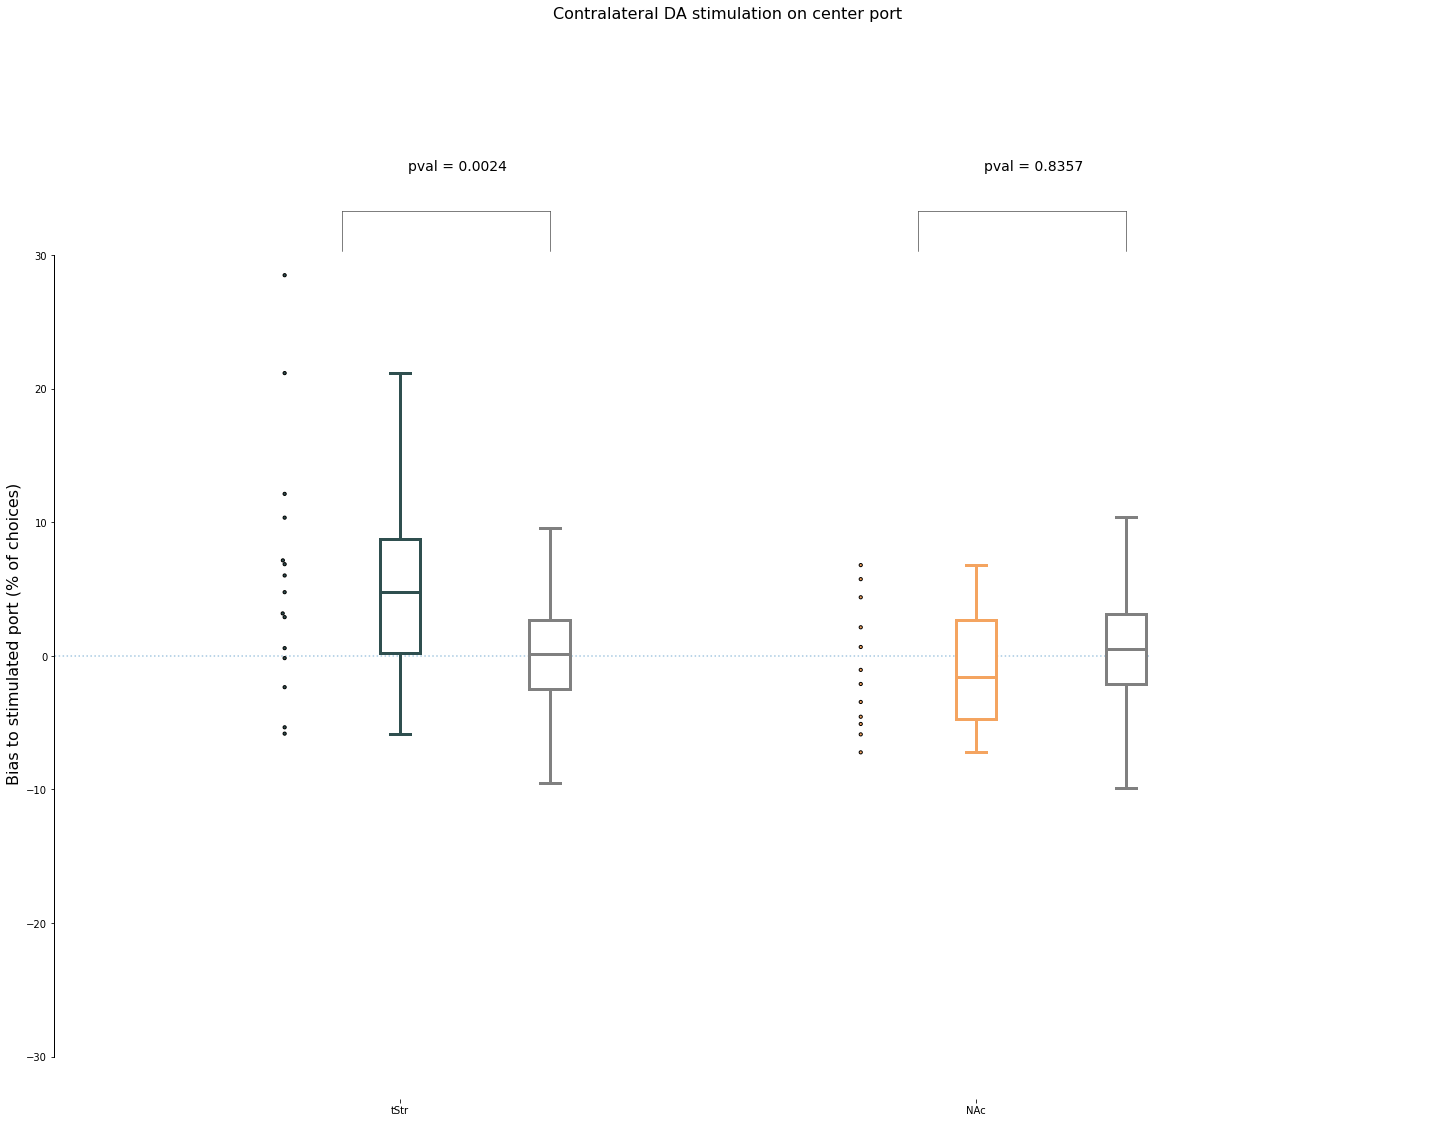

In [14]:
fig, es, dtc = make_figure_opto_da_boxplots(opto_df_sel, hor = ['tStr', 'NAc'])
                                                # tit='Contralateral DA stimulation on center port')
plt.show(fig)
# uncomment here to save the plot
# data_directory = ''
fig.savefig('dopamine_optostimulation_centerport_incongruent.pdf',
            transparent=True, bbox_inches='tight')

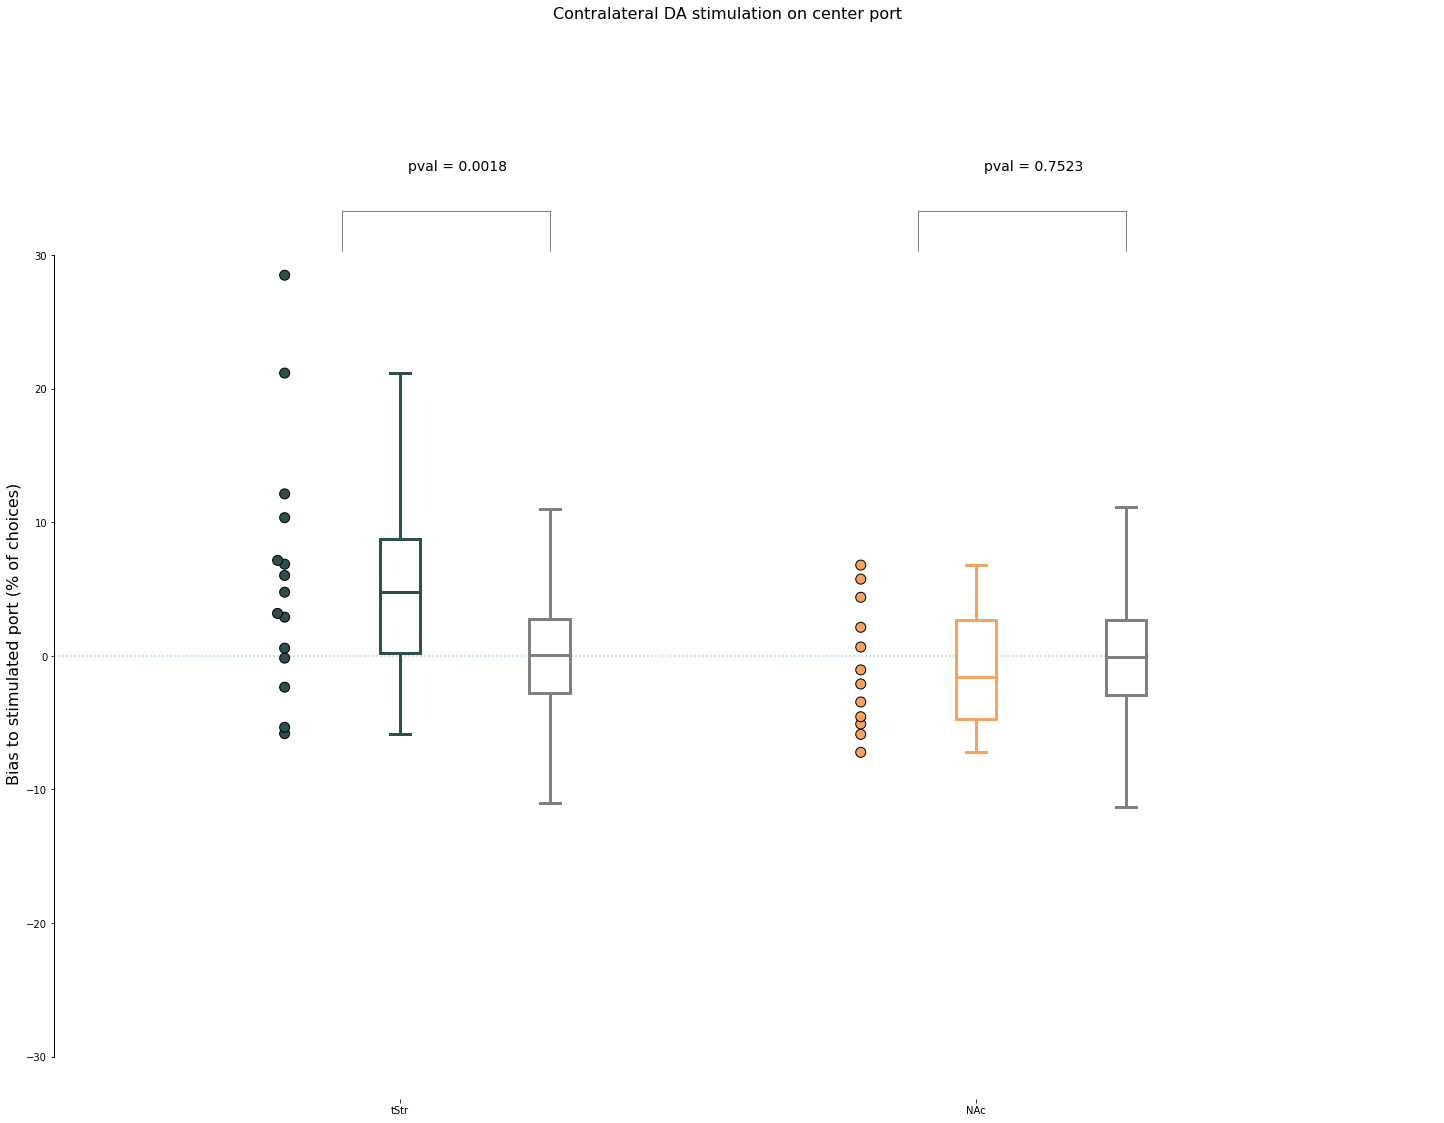

In [34]:
fig.fig

In [30]:
es

[1.4483917870681242, -0.19070203657772694]

In [29]:
w_p = stats.wilcoxon(list(dtc[0])).pvalue
print(f"wilcoxon to zero pval = {w_p}")


wilcoxon to zero pval = 0.01806640625


In [15]:
# save the data from the figure
import sys
sys.path.append('../../utils')
from excel_saver import scatter_to_excel
scatter_to_excel(fig.fig, '../../graphs_excel_format/figure_4d-4mW_data.xlsx')

Data has been saved to ../../graphs_excel_format/figure_4d-4mW_data.xlsx


#### Generate **Figure 6F**

In [16]:
# Subselect the dataframe based on some conditions
#### conditions
# remove sessions in which initially the mouse is very bias
conditions = opto_df.Protocol.isin(['Aud_Psycho', 'Auditory'])
conditions = np.logical_and(conditions, extreme_ini_bias < opto_df.InitialBias)
conditions = np.logical_and(conditions, (100 - extreme_ini_bias) > opto_df.InitialBias)
# select those sessions for which the stimulation is not labeled as contralateral
# as the stimulation was bilateral
conditions = np.logical_and(conditions, opto_df.Contralateral==False)
# select those sessions in which the stimulation happens when the animal is in the cent port
# this tests for state-action associations
conditions = np.logical_and(conditions, opto_df.StimPort=='Side')
# conditions = np.logical_and(conditions, opto_df.FiberArea=='tStr')

opto_df_sideport = opto_df[conditions].copy()

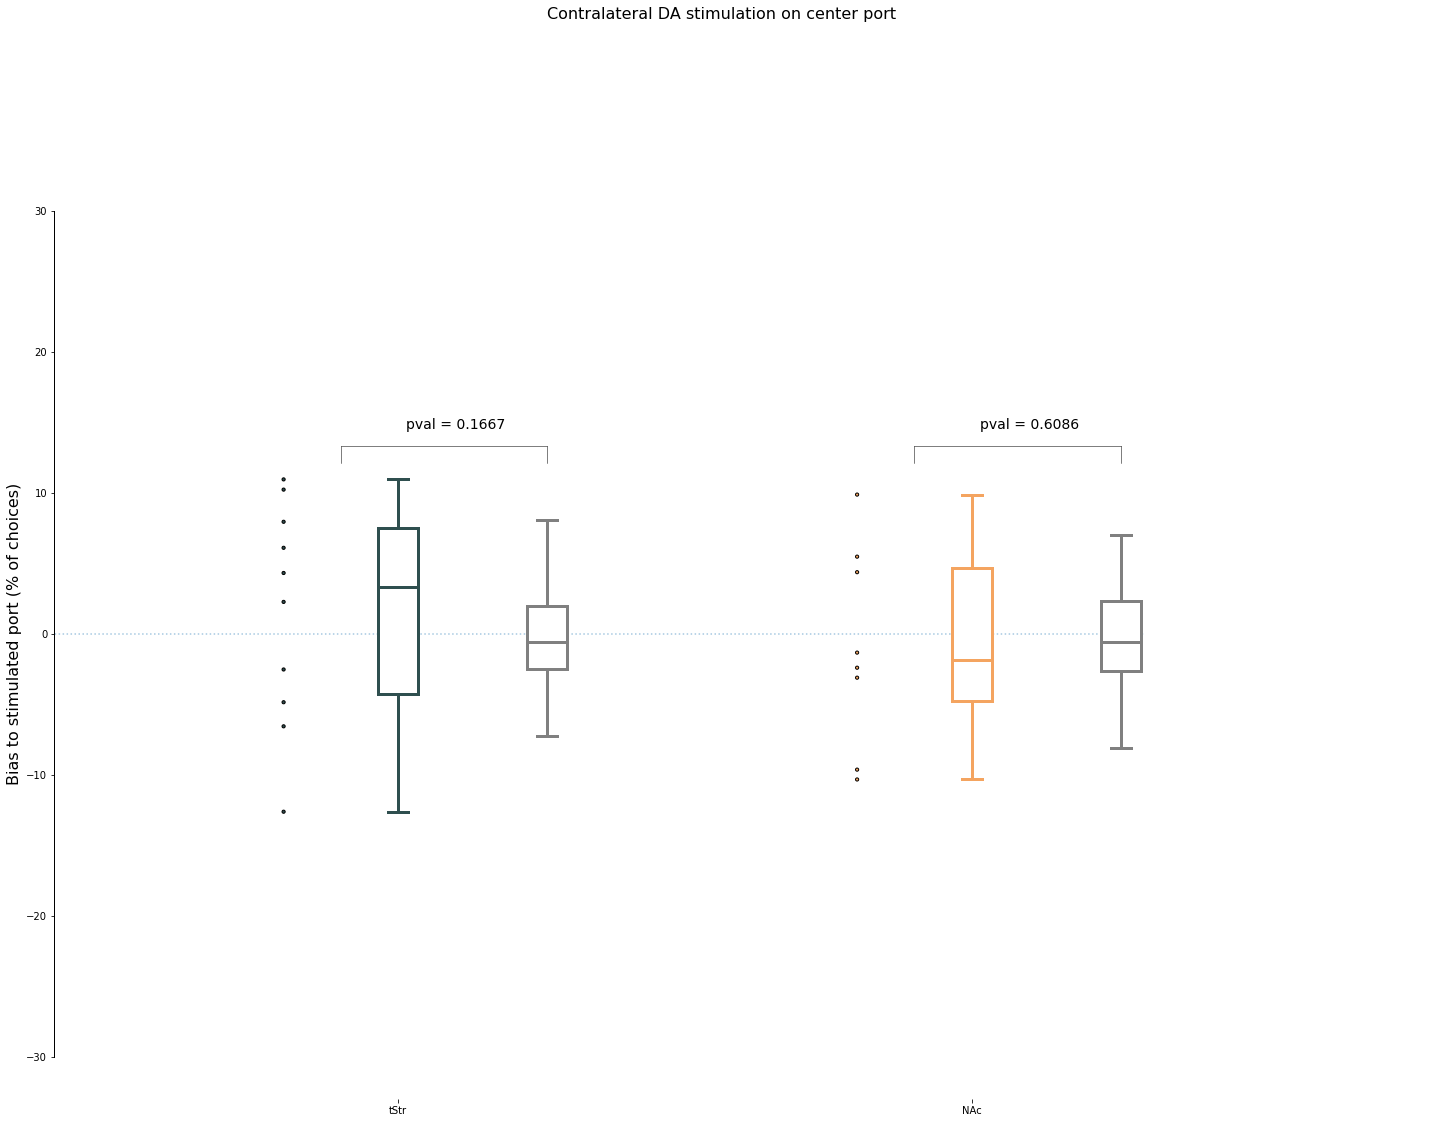

In [17]:
fig, es2, dtc = make_figure_opto_da_boxplots(opto_df_sideport, hor = ['tStr', 'NAc'])
                                                # tit='Bilateral tStr-DA stimulation\non side port')
plt.show(fig)
# uncomment here to save the plot
# data_directory = ''
fig.savefig('dopamine_optostimulation_sideport.pdf',
            transparent=True, bbox_inches='tight')

In [18]:
# save the data from the figure
import sys
sys.path.append('../../utils')
from excel_saver import save_figure_data_to_excel
scatter_to_excel(fig.figure, '../../graphs_excel_format/figure_4f-4mW_data.xlsx')

Data has been saved to ../../graphs_excel_format/figure_4f-4mW_data.xlsx


In [38]:
es2

[0.3991582100783475, -0.20997860979740016]

In [40]:
w_p = stats.wilcoxon(list(dtc[1])).pvalue
print(f"wilcoxon to zero pval = {w_p}")

wilcoxon to zero pval = 0.84375


In [ ]:
# Make a way to show all the psych curves. Try the difference curve of the session

In [ ]:
# save the opto df to have it handy
from google.colab import drive
drive.mount("/content/drive")
# save
# opto_df_sel.to_csv('/content/drive/My Drive/opto_df_sel.csv', index=False)
# load
opto_df_sel = pd.read_csv('/content/drive/My Drive/opto_df_sel.csv')

Mounted at /content/drive


In [ ]:
opto_df_sel.SessionID.unique()

array(['DAopto-01 Apr05 14:04', 'DAopto-01 Apr07 12:50',
       'DAopto-01 Apr08 13:10', 'DAopto-01 Apr11 17:43',
       'DAopto-02 Apr05 14:11', 'DAopto-03 Apr05 15:00',
       'DAopto-03 Apr07 13:27', 'DAopto-03 Apr08 13:59',
       'DAopto-03 Apr12 13:28', 'DAopto-04 Apr07 13:31',
       'DAopto-04 Apr08 14:03', 'DAopto-04 Apr12 13:24',
       'DAopto-05 Apr05 15:47', 'DAopto-05 Apr06 12:50',
       'DAopto-05 Apr08 14:52', 'DAopto-05 Apr12 14:12',
       'DAopto-06 Mar30 15:28', 'DAopto-06 Apr07 16:22',
       'DAopto-06 Apr08 14:48', 'DAopto-06 Apr11 15:53',
       'DAopto-07 Apr06 13:35', 'DAopto-07 Apr07 15:06',
       'DAopto-07 Apr08 15:29', 'DAopto-07 Apr11 16:32',
       'DAopto-07 Apr12 14:58', 'DAopto-08 Apr06 13:33',
       'DAopto-08 Apr07 15:08', 'DAopto-08 Apr08 15:33',
       'DAopto-08 Apr11 16:36', 'DAopto-09 Mar30 16:11',
       'DAopto-09 Apr06 14:15', 'DAopto-09 Apr07 15:51',
       'DAopto-09 Apr08 16:19', 'DAopto-09 Apr11 17:09',
       'DAopto-09 Apr12 15:48',

In [ ]:
# select the sessions in opto_df_sel
dao_df_sel = dao_df[dao_df.SessionID.isin(opto_df_sel.SessionID)]


In [ ]:
dao_df_sel.SessionID.unique()

array(['DAopto-01 Apr05 14:04', 'DAopto-01 Apr07 12:50',
       'DAopto-01 Apr08 13:10', 'DAopto-01 Apr11 17:43',
       'DAopto-02 Apr05 14:11', 'DAopto-03 Apr05 15:00',
       'DAopto-03 Apr07 13:27', 'DAopto-03 Apr08 13:59',
       'DAopto-03 Apr12 13:28', 'DAopto-04 Apr07 13:31',
       'DAopto-04 Apr08 14:03', 'DAopto-04 Apr12 13:24',
       'DAopto-05 Apr05 15:47', 'DAopto-05 Apr06 12:50',
       'DAopto-05 Apr08 14:52', 'DAopto-05 Apr12 14:12',
       'DAopto-06 Mar30 15:28', 'DAopto-06 Apr07 16:22',
       'DAopto-06 Apr08 14:48', 'DAopto-06 Apr11 15:53',
       'DAopto-07 Apr06 13:35', 'DAopto-07 Apr07 15:06',
       'DAopto-07 Apr08 15:29', 'DAopto-07 Apr11 16:32',
       'DAopto-07 Apr12 14:58', 'DAopto-08 Apr06 13:33',
       'DAopto-08 Apr07 15:08', 'DAopto-08 Apr08 15:33',
       'DAopto-08 Apr11 16:36', 'DAopto-09 Mar30 16:11',
       'DAopto-09 Apr06 14:15', 'DAopto-09 Apr07 15:51',
       'DAopto-09 Apr08 16:19', 'DAopto-09 Apr11 17:09',
       'DAopto-09 Apr12 15:48',

 - Progress: [####################] 100.0%


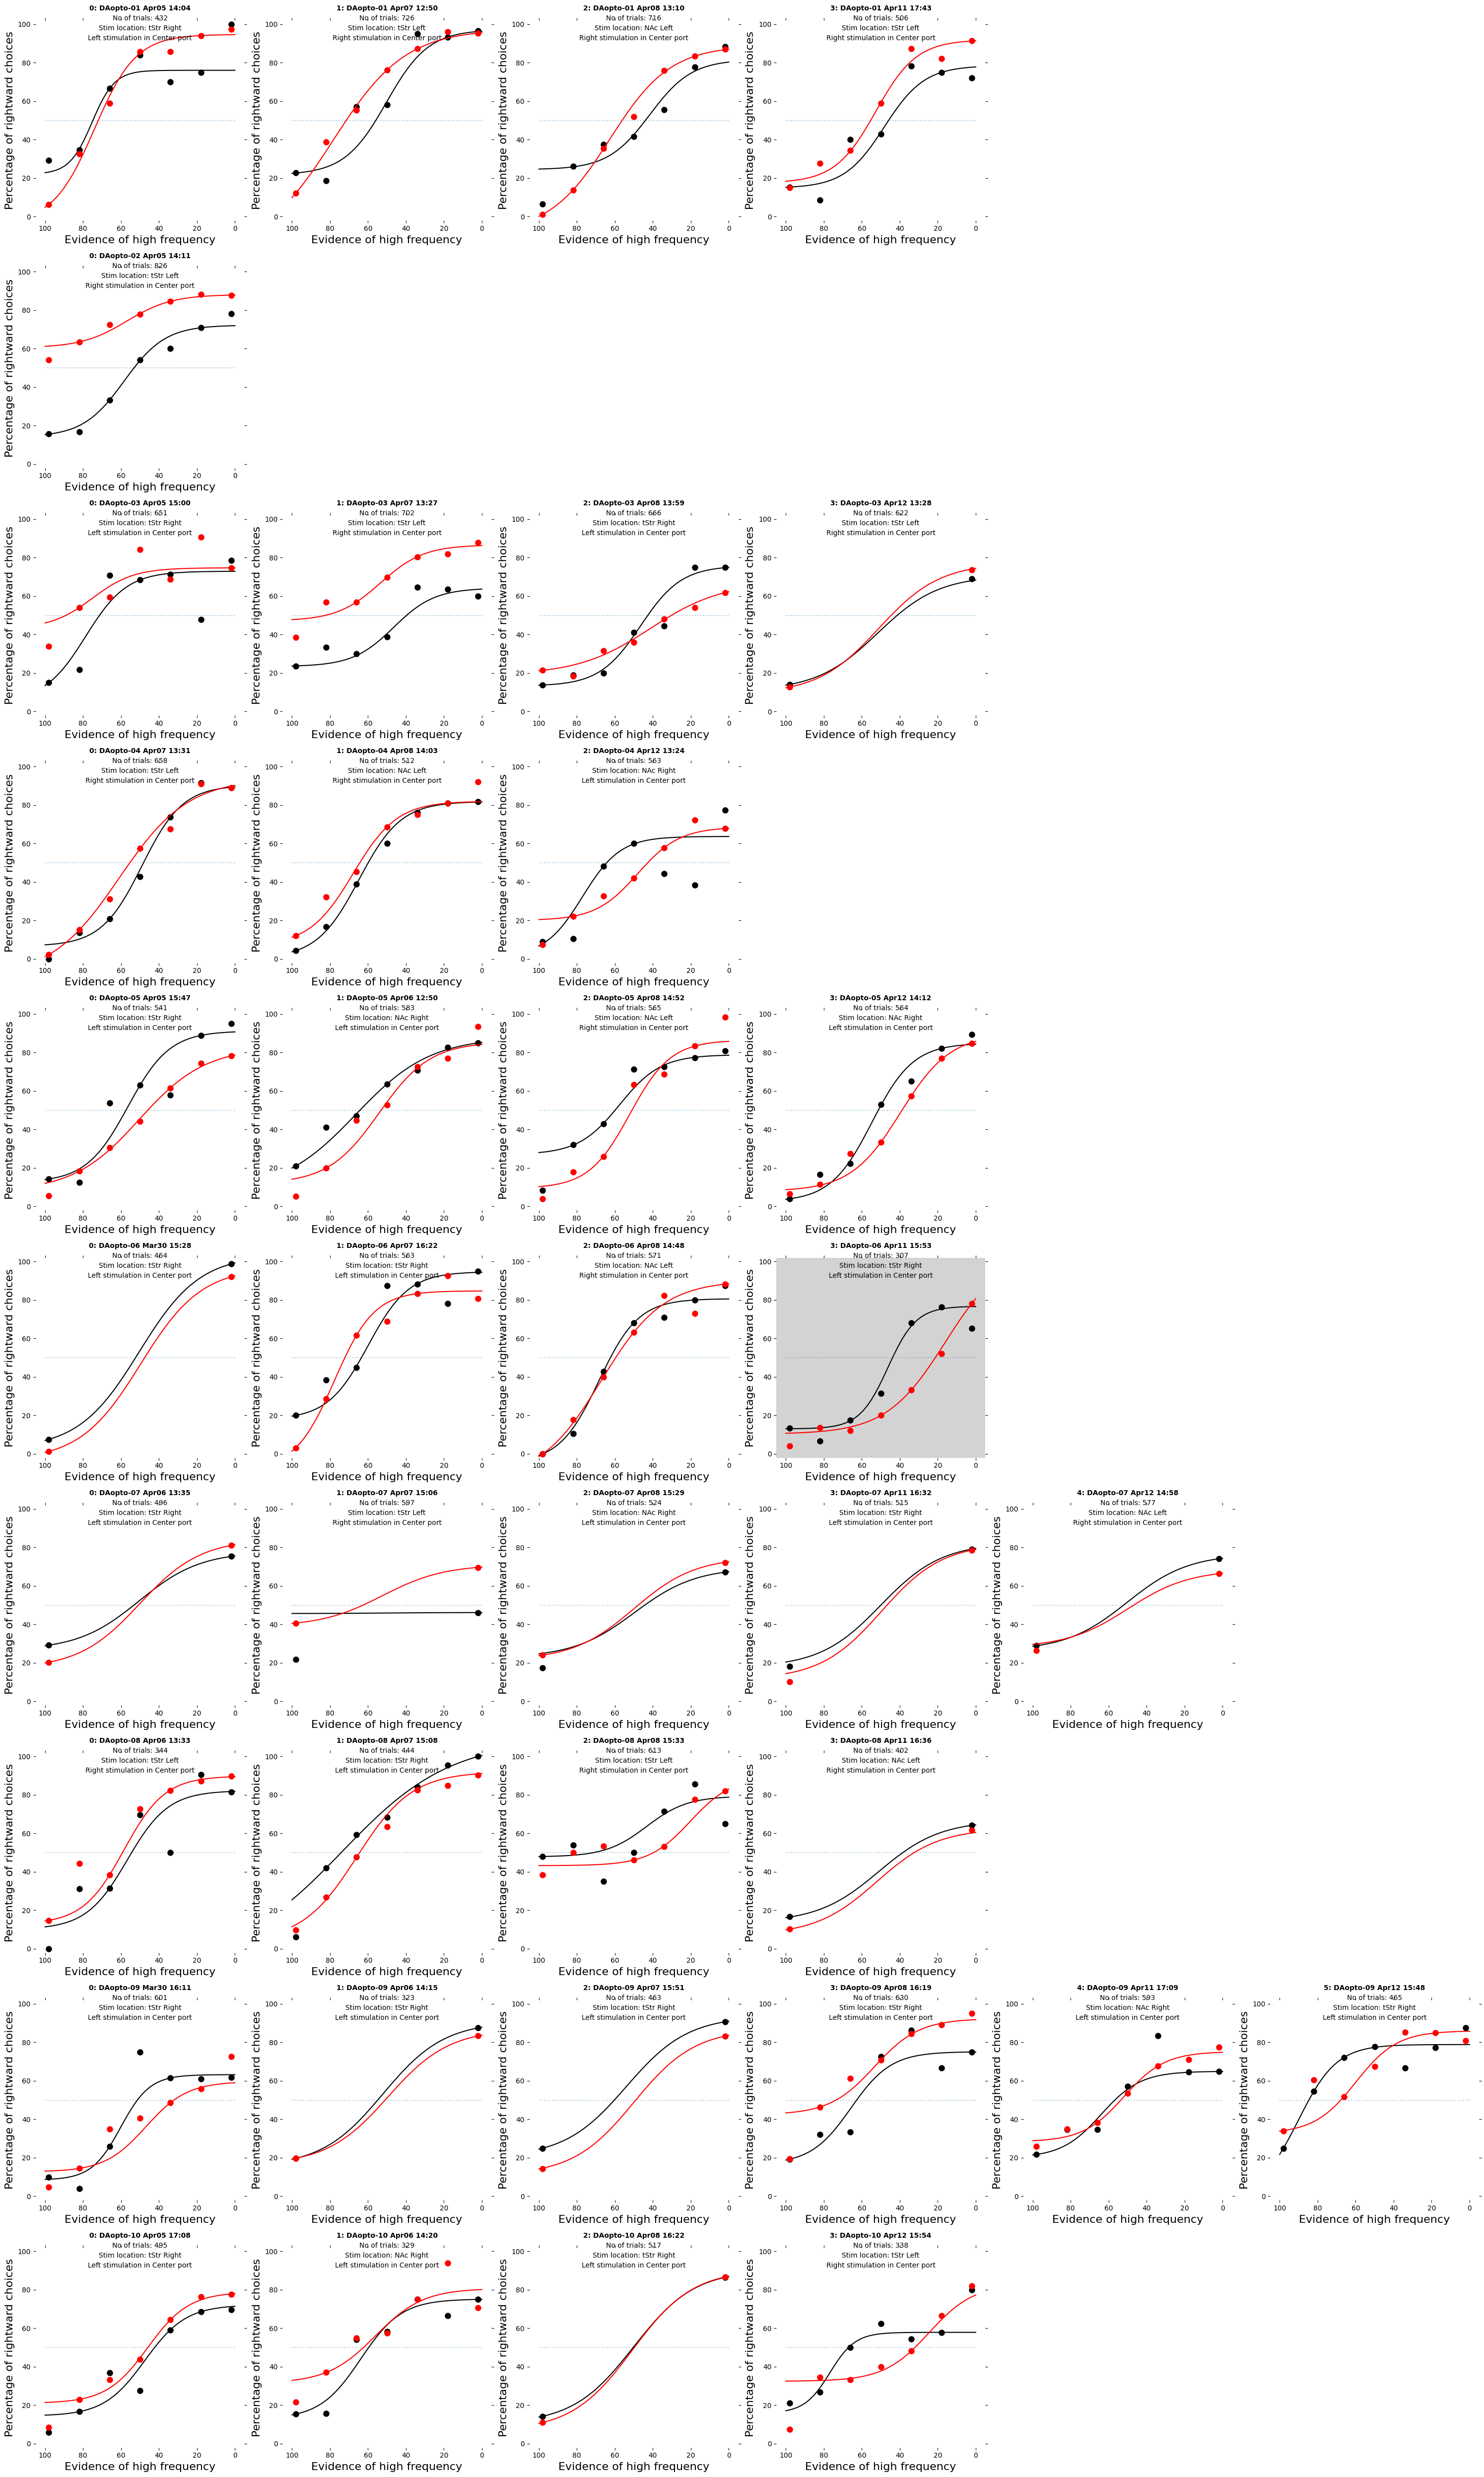

In [ ]:
example_session = 'DAopto-06 Apr11 15:53'
fig = make_figures.make_figure_opto_da_all_mice(dao_df_sel, ini_trials, ao_trials, example_session)
plt.show(fig)

In [ ]:
# group the sessions of the same condition

# in this case all are contralateral so we can merge the columns of AnimalID and Stimulation and that should work

# create a new column concatenating the content of "AnimalID" and "Stimulation"
dao_df_sel["AnimalID_Stimulation"] = dao_df_sel["AnimalID"] + "_" + dao_df_sel["Stimulation"]

In [ ]:
# separate tStr and NAc
fiber_location_list = [int(dao_df_sel.iloc[x].FullGUI["FiberLocation"]) for x in range(len(dao_df_sel))]
fiber_location_bool = [x == 1 for x in fiber_location_list]
dao_df_sel_ts = dao_df_sel[fiber_location_bool]
dao_df_sel_nac = dao_df_sel[np.logical_not(fiber_location_bool)]

In [ ]:
from mouse_behavior_analysis_tools.utils import plot_utils
import seaborn as sns

def plot_regression_hacked(df, ax, color, label, plot_points=True, show_fit=True):

    if ax is None:
        ax = plt.gca()

    trialsDif = np.array(df["TrialHighPerc"])
    sideSelected = np.array(df["FirstPoke"])

    difficulty, performance = cuf.get_choices(sideSelected, trialsDif)

    slope, bias, upper_lapse, lower_lapse = cuf.fit_custom_sigmoid(
        difficulty, performance
    )

    x = np.linspace(0, 100)

    if plot_points:
        ax.plot(difficulty, performance, "o", ms=8, color=color, label=label)

    if show_fit:
      sns.lineplot(
          x=x,
          y=cuf.sigmoid_func(x, *[slope, bias, upper_lapse, lower_lapse]),
          color=color,
          ci=None,
          ax=ax,
          label=label,
          legend=False,
      )

    return ax

def make_figure_opto_da_diffpsych(
    dao_df, ini_trials, ao_trials
):

    # Plot the data with the error bars for the random sampling,
    # and the custom fitting
    BRS = ["tStr", "NAc"]
    PS = ["Left", "Right"]
    PI = ["Center", "Side"]

    CondList = [
        (dao_df["TrialIndex"] < ini_trials),
        (dao_df["TrialIndex"] > ao_trials),
    ]
    ColorList = ["black", "red"]
    LabelList = ["Normal", "After opto"]

    # n_cols = dao_df.groupby("AnimalID")["AnimalID_Stimulation"].nunique().max()
    n_cols = 3

    fig, axs = plt.subplots(
        3, #len(pd.unique(dao_df["AnimalID"])),
        5,
        figsize=(5 * n_cols, 5 * 2), #len(pd.unique(dao_df["AnimalID"]))),
        facecolor="w",
        edgecolor="k",
    )

    fig.subplots_adjust(hspace=0.2, wspace=1)

    for ax in axs.ravel():
        ax.axis("off")

    row_counter = 0
    col_counter = 0

    for counter, session in enumerate(pd.unique(dao_df["AnimalID_Stimulation"])):
        session_df = dao_df[dao_df["AnimalID_Stimulation"] == session]

        ax = axs[col_counter, row_counter]
        ax.hlines(50, 0, 100, linestyles="dotted", alpha=0.4)

        # overlay fits if there are more than 2 tones
        show_fit = False
        if session_df.TrialHighPerc.nunique() > 2:
          show_fit = True
        for i, condition in enumerate(CondList):
            plot_regression_hacked(
                df=session_df[condition],
                ax=ax,
                color=ColorList[i],
                label=LabelList[i],
                plot_points=True,
                show_fit=show_fit,
            )

        ax.axis("on")

        try:
            if not ax.is_first_col():
                ax.set_ylabel("")
                ax.set_yticks([])
            if not ax.is_last_row():
                ax.set_xlabel("")
                ax.set_xticks([])
        except AttributeError:
            pass

        ax.set_ylim(-2.0, 102.0)
        # ax.legend(bbox_to_anchor=(1.05, 1), loc=0, borderaxespad=0.)
        ax.tick_params(
            which="both",
            top="off",
            bottom="on",
            left="on",
            right="off",
            labelleft="on",
            labelbottom="on",
        )
        # get rid of the frame
        # for spine in ax.spines.values():
        #     spine.set_visible(False)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)

        plt.tight_layout()

        ax.invert_xaxis()

        # ax.get_legend().remove()
        ax.text(
            0.5,
            1.05,
            session,
            horizontalalignment="center",
            fontweight="bold",
            transform=ax.transAxes,
        )
        ax.text(
            0.5,
            .98,
            "No of trials: "
            + str(len(session_df[(session_df["AnimalID_Stimulation"] == session)])),
            horizontalalignment="center",
            transform=ax.transAxes,
        )
        # Fiber location
        fl = BRS[int(session_df.iloc[0].FullGUI["FiberLocation"]) - 1]
        # Side
        side = session_df.Stimulation.unique()[0]
        # ax.text(
        #     0.5,
        #     0.95,
        #     "Stim location: " + fl + " " + side,
        #     horizontalalignment="center",
        #     transform=ax.transAxes,
        # )
        # If the fiber is on the right, flip both axes
        if side == "Right":
            ax.invert_xaxis()
            ax.invert_yaxis()

        # Port stimulated
        port = PI[int(session_df.iloc[0].FullGUI["OptoState"]) - 1]
        portside = PS[int(session_df.iloc[0].FullGUI["JOPSide"]) - 1]
        ax.text(
            0.5,
            0.92,
            portside + " stimulation in " + port + " port",
            horizontalalignment="center",
            transform=ax.transAxes,
        )

        # remove x and y tick labels
        ax.set_xticklabels([])
        ax.set_yticklabels([])

        # remove top and right ticks
        ax.tick_params(
            which="both",
            top=False,
            right=False,
        )


        # update_progress((an_counter + 1) / len(pd.unique(dao_df["AnimalID"])))
        # print(str(row_counter) + "/" + str(col_counter) + " / " + str(len(axs)))
        row_counter += 1
        if row_counter == 5:
            row_counter = 0
            col_counter += 1

    axs[1,0].set_ylabel("Percentage of contralateral choices", fontsize=22)
    axs[2,2].set_xlabel("Evidence for contralateral movement", fontsize=22)

    return fig

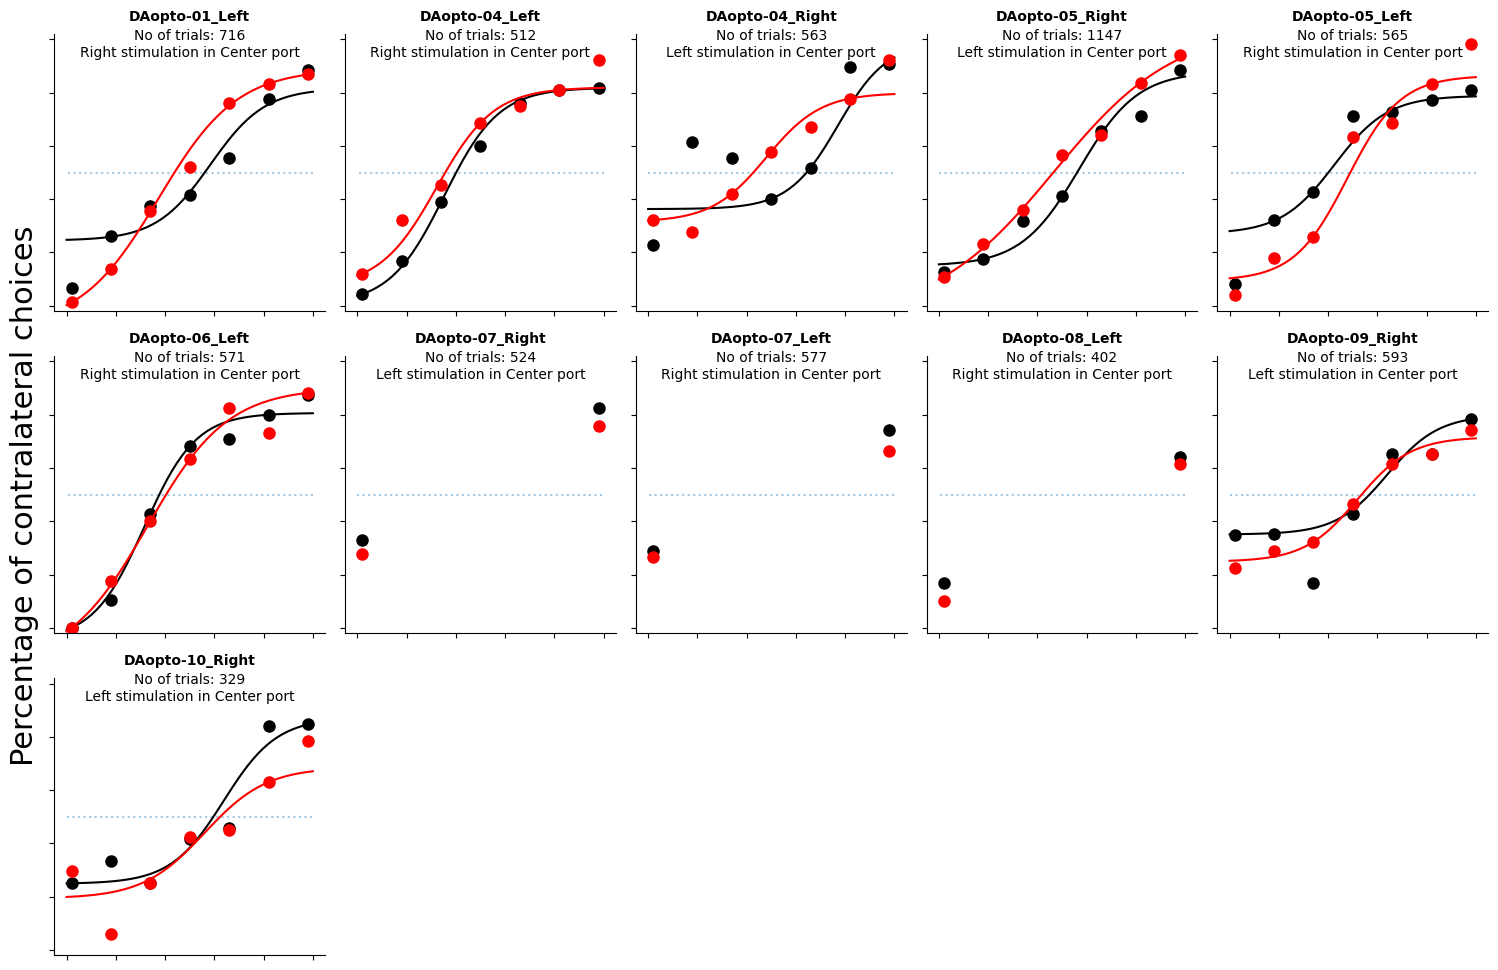

In [ ]:
fig = make_figure_opto_da_diffpsych(dao_df_sel_nac, ini_trials, ao_trials)
plt.show(fig)


In [ ]:
fig.savefig('DAstim_all_psychometrics_NAc.pdf', dpi=300, bbox_inches='tight')

In [ ]:

# Not working
# data_directory = "/content/drive/My Drive/"
# plt.savefig(data_directory + 'dopamine_optostimulation_tStr_state-action_contralateral_merge.pdf',
#             transparent=True, bbox_inches='tight')

# Save the figure as pdf
from google.colab import files

# Not working either
fig.savefig('dopamine_optostimulation_tStr_state-action_contralateral_merge.pdf',
            transparent=True, bbox_inches='tight', dpi=1000)
files.download('dopamine_optostimulation_tStr_state-action_contralateral_merge.pdf')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
dao_df_sel.head()

,AnimalID,ExperimentalGroup,SessionTime,FullSessionTime,Protocol,Stimulation,Muscimol,RewardChange,RewardChangeBlock,CenterPortDuration,...,CumulativeTrialNumber,CumulativeTrialNumberByProtocol,CurrentPastPerformance20,CurrentPastPerformance100,NoOfCenterPokes,MiddleWaitTime,TrialInitiationTime,RightBias,TrialsSpeed,PrevTrialSuccess
12254,DAopto-01,DAoptostimulation,Apr05 14:04,2022-04-05 14:04:00,Aud_Psycho,Right,No,No,0,0.2,...,11311,4739.0,NaN,NaN,2,0.2166,1.7951,0.02,NaN,1.0
12255,DAopto-01,DAoptostimulation,Apr05 14:04,2022-04-05 14:04:00,Aud_Psycho,Right,No,No,0,0.2,...,11312,4740.0,NaN,NaN,7,0.2162,0.3629,0.02,NaN,1.0
12256,DAopto-01,DAoptostimulation,Apr05 14:04,2022-04-05 14:04:00,Aud_Psycho,Right,No,No,0,0.2,...,11313,4741.0,NaN,NaN,1,0.2733,NaN,0.02,24.200379,1.0
12257,DAopto-01,DAoptostimulation,Apr05 14:04,2022-04-05 14:04:00,Aud_Psycho,Right,No,No,0,0.2,...,11314,4742.0,NaN,NaN,3,0.2593,0.2836,0.02,30.042961,1.0
12258,DAopto-01,DAoptostimulation,Apr05 14:04,2022-04-05 14:04:00,Aud_Psycho,Right,No,No,0,0.2,...,11315,4743.0,NaN,NaN,3,0.2859,0.2603,0.02,38.665275,1.0


In [ ]:
def get_general_right_bias_hacked(df_one, df_two):
    "returns the general bias to the right, between df_one and df_two"
    # mean choices for each data frame for each difficulty
    tdone = np.array(df_one["TrialHighPerc"])
    ssone = np.array(df_one["FirstPoke"])
    _, perf_one = cuf.get_choices(ssone, tdone)
    tdtwo = np.array(df_two["TrialHighPerc"])
    sstwo = np.array(df_two["FirstPoke"])
    _, perf_two = cuf.get_choices(sstwo, tdtwo)

    return perf_one - perf_two

def get_dopamine_optostimulation_differences_dataframe_hacked(
    dao_df, ini_trials, ao_trials
):
    # Generate another dataset for every session containing information
    # about the difference between
    # the optostimulated trials and the normal ones,
    # keeping all the different type of trials separate

    BRS = ["tStr", "NAc"]
    PS = ["Left", "Right"]
    PI = ["Center", "Side"]
    CondList = [
        (dao_df["TrialIndex"] < ini_trials),
        (dao_df["TrialIndex"] > ao_trials),
    ]

    cols = [
        "AnimalID",
        "SessionID",
        "Ntrials",
        "Protocol",
        "Stim",
        "FiberSide",
        "FiberArea",
        "StimSide",
        "StimPort",
        "Contralateral",
        "InitialBias",
        "Bias",
        "BiasToStimPort",
    ]
    data = np.empty(
        [len(pd.unique(dao_df["SessionID"])), len(cols)], dtype=object
    )

    for i, sessionid in enumerate(pd.unique(dao_df["SessionID"])):
        # get dataframe of the session
        session_df = dao_df[dao_df["SessionID"] == sessionid].copy()
        # get animal name
        animalid = session_df.AnimalID.unique()[0]
        # get number of trials
        ntrials = session_df.shape[0]
        # protocol
        protocol = session_df.Protocol.unique()[0]
        # is it a stimulated session?
        stim = session_df.Stimulation.unique()[0] != "NoStimulation"
        # which fiber was plugged in
        fiberside = session_df.Stimulation.unique()[0]
        # which brain area is this fiber over
        fiberarea = BRS[int(session_df.iloc[0].FullGUI["FiberLocation"]) - 1]
        # which one of the side ports, or trial type, was stimulated
        stimside = PS[int(session_df.iloc[0].FullGUI["JOPSide"]) - 1]
        # in which one of the ports did stimulation occurred
        stimport = PI[int(session_df.iloc[0].FullGUI["OptoState"]) - 1]
        # is the fiber contralateral to the port
        contralateral = True
        if (fiberside == stimside) or fiberside == "Both":
            contralateral = False
        # what is the initial bias of the mouse in trials before stimulation
        ini_sess = session_df[session_df.TrialIndex < ini_trials].copy()
        initialbias = np.mean(
            cuf.get_choices(ini_sess["FirstPoke"], ini_sess["TrialHighPerc"])[1]
        )
        # what are the biases of that session after opto
        bias = get_general_right_bias_hacked(
            session_df[CondList[1]], session_df[CondList[0]]
        )
        # is this bias positive towards the stimulated port?
        if stimside == "Right":
            biastostimport = bias
        if stimside == "Left":
            biastostimport = bias * -1

        # fill
        data[i] = [
            animalid,
            sessionid,
            ntrials,
            protocol,
            stim,
            fiberside,
            fiberarea,
            stimside,
            stimport,
            contralateral,
            initialbias,
            bias,
            biastostimport,
        ]

        update_progress(i / len(pd.unique(dao_df["SessionID"])))

    # create dataframe
    opto_df = pd.DataFrame(data, columns=cols)
    update_progress(1)

    return opto_df

In [ ]:
diffs_by_trial_type_df = get_dopamine_optostimulation_differences_dataframe_hacked(dao_df_sel, ini_trials,
                                                                 ao_trials)

 - Progress: [####################] 100.0%


In [ ]:
# add another column with the trial types
trial_type = np.sort(dao_df_sel.TrialHighPerc.unique())

# in each row, add the array of trial types
diffs_by_trial_type_df["TrialHighPerc"] = diffs_by_trial_type_df.apply(
    lambda row: trial_type, axis=1
)

# go row by row, and if there are only two values in BiasToStimPort, change TrialHighPerc
simple_task_types = [trial_type[0], trial_type[-1]]
for i, row in diffs_by_trial_type_df.iterrows():
    if len(row.BiasToStimPort) == 2:
        diffs_by_trial_type_df.at[i, "TrialHighPerc"] = simple_task_types

In [ ]:
diffs_by_trial_type_df.loc[7]


,7
AnimalID,DAopto-03
SessionID,DAopto-03 Apr12 13:28
Ntrials,622
Protocol,Auditory
Stim,True
FiberSide,Left
FiberArea,tStr
StimSide,Right
StimPort,Center
Contralateral,True


In [ ]:
# melt the df and create rows for each value of BiasToStimPort
df_to_plot = diffs_by_trial_type_df.explode(["BiasToStimPort", "TrialHighPerc"])

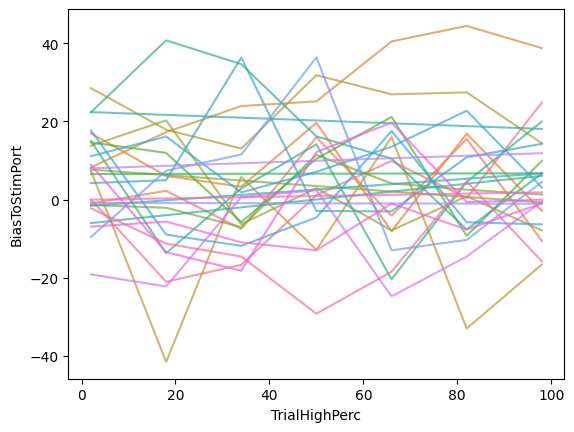

In [ ]:
# plot
from matplotlib import pyplot as plt
import seaborn as sns

sns.lineplot(
    x="TrialHighPerc",
    y="BiasToStimPort",
    data=df_to_plot,
    alpha=.7,
    hue="SessionID",
    legend=False,


)

plt.show()

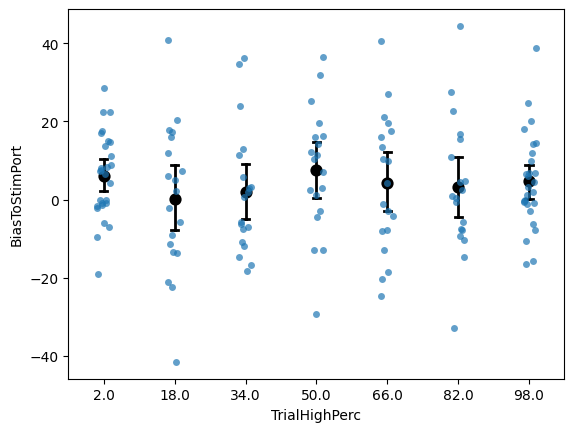

In [ ]:
sns.stripplot(
    x="TrialHighPerc",
    y="BiasToStimPort",
    data=df_to_plot,
    alpha=.7,
    )
# overlay a pointplot
sns.pointplot(
    x="TrialHighPerc",
    y="BiasToStimPort",
    data=df_to_plot,
    join=False,
    capsize=0.1,
    # color black
    color="black",
    errwidth=2,
)
plt.show()